#### 商品特徵欄位
--檔期接續問題
--計算時間問題
##### 目前已可取得：
* 商品ID [business_hour_guid]
* 品牌：將不同品牌使用Label Encoding 加以標示(?)
* 檔次原價 [item_orig_price]
* 檔次促銷價格 [item_price]
* 關鍵字：先挑出根據出現詞頻最高的5~10個行銷用詞(如：熱銷、買_送_...等)，再計算每個商品標題中含有行銷用詞之次數(或將其分等級)
* 品類：從order檔案與deal檔案結合	 [code]	
* 促銷與否：結合discount檔案，看其商品是否有加入促銷活動(1 or 0)[is_Discount] 
* 分期：計算該商品是否有提供分期付款優惠 
   [installment_3months] [installment_6months]	[installment_12months] [deny_installment]
* 配送時間：V [shippingdate]
* 上架月份：利用business_hour_order_time_s找出檔次上架之月份(若為累積檔次取其出現頻率最多者) [product_launch_month]	
* 上架星期：利用business_hour_order_time_s找出該天為星期幾(若為累積檔次取其出現頻率最多者) [product_launch_weekday]
* 上架時間：利用business_hour_order_time_s找出上架時間點(以24小時為欄位)  [product_launch_hour]
* 檔期長度(天數)：利用business_hour_order_time_s、business_hour_order_time_e欄位相減	(可先做) [campagin_period]
* 是否為長銷型商品[longTern]
* 開賣前三天的銷量:利用order訂單與business_hour_order_time_s時間相減進行計算
* 是否預購：計算訂購與配送之時間差(若超過三週則設為預購，以1,0劃分) (可先做)[presales]
* 與同類商品的單位價格中位數比較：計算該產品的產品單位價格中位數，與其單位價格比較(使用百分比)[compare_cate_unit_price]
* 熱銷：觀察該商品上過熱銷排行榜的次數(用整個平台的每日銷量，判斷是否有為全平台的Top20)再除以檔期長度 取百分比 (新品可能會沒有?!)
* 可超取：可否超商取貨 [enable_isp]
* 單位價格（單一檔期)[unit_price]
* 總銷售產品單位量 (單一檔期)[quantity_sold_guid]
* 商品平均價格(全檔期)[avg_unit_price]
* 總銷售量(全檔期)[quantity_sold_allguid]

--消費熱衷區間、了解消費者pattern
#### 目標變數：
* 該商品於未來7.14.30.60.180天的預估銷量：利用order訂單與business_hour_order_time_s時間相減進行計算，除以總銷量取得百分比(可先做)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
pd.options.display.max_columns = 100

### 因為deal欄位有名稱遺漏問題，故要將其重新命名，並回存檔案

In [ ]:
deal=pd.read_csv("dealv2.csv")
deal=deal.reset_index()
deal.columns=['business_hour_guid', 'seller_GUID', 'business_hour_order_time_s',
       'business_hour_order_time_e', 'business_hour_deliver_time_s',
       'business_hour_deliver_time_e', 'pic_alt','zip_code', 'city_name',
       'district_name', 'item_name', 'item_orig_price', 'item_price',
       'item_default_daily_amount', 'event_name', 'event_title',
       'product_spec', 'shopping_cart', 'combo_pack_count',
       'quantity_multiplier', 'city_list', 'deal_acc_business_group_id',
       'acc_business_group_name', 'deal_type', 'is_travel_deal',
       'installment_3months', 'installment_6months', 'installment_12months',
       'deny_installment', 'shippingdate', 'is_long_contract',
       'develope_sales_id', 'operation_sales_id', 'slug', 'ordered_quantity',
       'ordered_total', 'category_list', 'freight_amount', 'enable_isp',
       'discount_price', 'is_wms', 'ancestor_business_hour_guid', 'code_name',
       'code']

In [ ]:
deal.to_csv("dealv2.csv",index=False)

### 與order合併

In [ ]:
order_ori =pd.read_csv("order.csv")
order_ori.rename(columns={'Unnamed: 4':'is_returned'}, inplace=True)
order_ori.head()

In [ ]:
df=pd.merge(order_ori,deal,how='left',on=['business_hour_guid','seller_GUID'])

### 將運送開始日期排序，找出有問題的欄位

In [ ]:
df.business_hour_deliver_time_e.sort_values(ascending= False).head(5)

* 因為檔次時間有問題的欄位(9999-...)不多，故直接刪除

In [ ]:
df=df.drop(index=[3079467,3081700,3474924])

In [ ]:
df=df.reset_index(drop=True)
df=df[:4080853]

### 將欄位轉換格式為datetime

In [ ]:
import datetime
for i in ['business_hour_order_time_s','create_time','business_hour_order_time_e','business_hour_deliver_time_s','business_hour_deliver_time_e']:
        df[i]=pd.to_datetime(df[i])
    

### 取出檔期開始之月份 時間點 星期幾 檔次長度 訂購與開始運送之天數差(用來計算是否有預購情況)

In [ ]:
df['product_launch_month']=df['business_hour_order_time_s'].apply(lambda x:x.month)
df['product_launch_hour']=df['business_hour_order_time_s'].apply(lambda x:x.hour)
df['product_launch_weekday']=df['business_hour_order_time_s'].apply(lambda x:x.weekday())
df['campagin_period']=(df['business_hour_order_time_e']-df['business_hour_order_time_s']).apply(lambda x:x.days)
df['order_deliver_days']=(df['business_hour_deliver_time_s']-df['business_hour_order_time_s']).apply(lambda x : x.days )
def trans(x):
    if x>=3:
        return 1
    elif x<3:
        return 0
    else:
        return np.NaN

df["presales"]=df['order_deliver_days'].apply(trans)
df['purchase_year']=df['create_time'].apply(lambda x:x.year)


##  挑選 2015~2019間的交易紀錄，約有2,126,469筆交易紀錄

In [ ]:
df=df[df.purchase_year>=2015]
df.shape

In [ ]:
df.to_csv("df.csv",index=False)

## =>從此讀新檔案

In [7]:
df=pd.read_csv("df.csv",low_memory=False)

### 找出商品檔次繼承關係

* 刪除重複檔次ID

In [124]:
tempdf=df[['business_hour_guid','ancestor_business_hour_guid']].drop_duplicates(['business_hour_guid'])

## 建立查詢字典

In [125]:
##將兩欄位位置對調，更名(改名為檔次1,2...)
bhgnoNaN=tempdf[tempdf.ancestor_business_hour_guid.isnull()==False]
dictionary=bhgnoNaN[["ancestor_business_hour_guid","business_hour_guid"]]
dictionary=dictionary.rename(columns={'ancestor_business_hour_guid':'business_hour_guid','business_hour_guid':'business_hour_guid_1'})

* 先找出檔次ID與前次檔次ID，將已無前檔次ID的檔次作為開頭表格(ancestor_business_hour_guid.isnull()==True)

In [126]:
bhgwithNaN=tempdf[tempdf.ancestor_business_hour_guid.isnull()==True]
bhgwithNaN=bhgwithNaN[['business_hour_guid']]
tmp=pd.merge(bhgwithNaN,dictionary,how="left")
tmp.head()

,business_hour_guid,business_hour_guid_1
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,NaN
1,EFBA954B-B665-4FF1-B4ED-857B915FB840,NaN
2,48FF7620-2D38-4673-A012-30EC61C40065,NaN
3,33012183-5329-4C92-B0C9-3D2FE3BA316A,NaN
4,39713041-01D7-4402-97FB-C361A6C68E95,NaN


In [127]:
##沒有前次檔期的商品後面就會顯示NaN,商品最多有17個檔期
i=1
while True:
    dictcol1='business_hour_guid_'+str(i)
    dictcol2='business_hour_guid_'+str(i+1)
    dictionary.columns=[dictcol1,dictcol2]
    tmp=pd.merge(tmp,dictionary,how="left")
    print(tmp[tmp[dictcol2].isnull()==False].shape)
    if(tmp[dictcol2].isnull().all()==True):
        break
    else:
        i=i+1

(727, 3)
(497, 4)
(341, 5)
(235, 6)
(158, 7)
(116, 8)
(92, 9)
(75, 10)
(59, 11)
(34, 12)
(22, 13)
(14, 14)
(10, 15)
(5, 16)
(3, 17)
(0, 18)


In [128]:
tmp['list']=tmp.apply(lambda x: x.tolist(), axis=1)

### List中 去除空值

In [130]:
def delNaN(x):
    cleanedList = [i for i in x if str(i) != 'nan']
    return cleanedList
tmp['list']=tmp['list'].apply(delNaN)

In [132]:
tmp['present_guid']=tmp['list'].apply(lambda x:x[-1])
#tmp.to_csv("guid_rela.csv",index=False)

In [3]:
guid_connection=pd.read_csv("guid_rela.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [279]:
tmp[tmp.business_hour_guid_2.isnull()==False].shape

(911, 20)

In [134]:
guidlist=tmp[["present_guid","list"]]

In [140]:
guidlist

,business_hour_guid,list
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,[B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B]
1,EFBA954B-B665-4FF1-B4ED-857B915FB840,[EFBA954B-B665-4FF1-B4ED-857B915FB840]
2,48FF7620-2D38-4673-A012-30EC61C40065,[48FF7620-2D38-4673-A012-30EC61C40065]
3,33012183-5329-4C92-B0C9-3D2FE3BA316A,[33012183-5329-4C92-B0C9-3D2FE3BA316A]
4,39713041-01D7-4402-97FB-C361A6C68E95,[39713041-01D7-4402-97FB-C361A6C68E95]
5,B7ED6368-B1CF-4B6F-BA09-033ED04414E3,[B7ED6368-B1CF-4B6F-BA09-033ED04414E3]
6,F92B1A31-F411-4B4B-8B7F-2317CC665F7B,[F92B1A31-F411-4B4B-8B7F-2317CC665F7B]
7,BCC8D514-2409-476F-81CB-88EC7451FF01,[BCC8D514-2409-476F-81CB-88EC7451FF01]
8,08641E7A-4BBA-42D5-B270-046F1619B7CD,[08641E7A-4BBA-42D5-B270-046F1619B7CD]
9,3311B9BC-C422-4E76-AD11-6552D2DB5B9F,[3311B9BC-C422-4E76-AD11-6552D2DB5B9F]


### 合併guidlist與order

In [142]:
guidlist.columns=['business_hour_guid','list']

In [148]:
df=pd.merge(df,guidlist,how="left")

In [159]:
#有些NaN值 直接以該檔期填充
df.list.fillna(df.business_hour_guid, inplace=True)

### 計算全檔期平均價格與總銷量

In [229]:
allcate=df[['business_hour_guid','subtotal','unit_price','quantity_multiplier','list']]

In [230]:
temp=allcate.drop_duplicates(['business_hour_guid'])[['business_hour_guid','unit_price','quantity_multiplier','list']]

In [231]:
cate=allcate.groupby('business_hour_guid')['subtotal'].sum().to_frame().reset_index()
temp=temp.merge(cate)

In [232]:
temp['quantity_sold']=(temp['subtotal']/temp['unit_price']).round(3)

In [235]:
temp=temp.rename(columns={'subtotal':'subtotal_guid','quantity_sold':'quantity_sold_guid'})
temp['subtotal_allguid']=0
temp['quantity_sold_allguid']=0
temp['avg_unit_price']=0
temp.head()

,business_hour_guid,unit_price,quantity_multiplier,list,subtotal_guid,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,205.0,1.0,[B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B],8405.0,41.0,0,0,0
1,EFBA954B-B665-4FF1-B4ED-857B915FB840,1090.0,1.0,[EFBA954B-B665-4FF1-B4ED-857B915FB840],32700.0,30.0,0,0,0
2,48FF7620-2D38-4673-A012-30EC61C40065,149.0,1.0,[48FF7620-2D38-4673-A012-30EC61C40065],4321.0,29.0,0,0,0
3,33012183-5329-4C92-B0C9-3D2FE3BA316A,199.0,2.0,[33012183-5329-4C92-B0C9-3D2FE3BA316A],18308.0,92.0,0,0,0
4,39713041-01D7-4402-97FB-C361A6C68E95,699.0,2.0,[39713041-01D7-4402-97FB-C361A6C68E95],44736.0,64.0,0,0,0


In [276]:
temp.to_csv("allguid.csv",index=False)

In [242]:
temp[temp.business_hour_guid=='E0336F98-92BA-4BAD-BBB7-6087BBD71192']

,business_hour_guid,unit_price,quantity_multiplier,list,subtotal_guid,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price
8455,E0336F98-92BA-4BAD-BBB7-6087BBD71192,739.0,1.0,"[0D7C0FBA-E8F9-4B92-97B7-686051FFF8E9, E0336F9...",50252.0,68.0,0,0,0


### 利用迴圈找出全檔期總消費額、銷售量、平均單位價格

In [271]:
for i in range(len(temp)):
    lis=temp.loc[i,'list']
    if(type(lis)==str):
        temp.loc[i,'subtotal_allguid']=temp.loc[i,'subtotal_guid']
        temp.loc[i,'quantity_sold_allguid']=temp.loc[i,'quantity_sold_guid']
        temp.loc[i,'avg_unit_price']=temp.loc[i,'unit_price']
    else:
        allsubtotal=0
        allguid=0
        avgunitprice=0
        for k in lis:
            allsubtotal=allsubtotal+temp.loc[temp.business_hour_guid==k,'subtotal_guid'].values[0]
            allguid=allguid+temp.loc[temp.business_hour_guid==k,'quantity_sold_guid'].values[0]
            avgunitprice=avgunitprice+temp.loc[temp.business_hour_guid==k,'unit_price'].values[0]
        avgunitprice=avgunitprice/len(lis)
        temp.loc[i,'subtotal_allguid']=allsubtotal
        temp.loc[i,'quantity_sold_allguid']=allguid
        temp.loc[i,'avg_unit_price']=avgunitprice

In [6]:
temp[temp.subtotal_allguid>temp.subtotal_guid]

,business_hour_guid,unit_price,quantity_multiplier,list,subtotal_guid,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price
1879,9062E9FE-3E87-470B-A370-5D4B078A7907,320.0,1.0,"['B5C27421-91DF-460F-B52A-EF2C9B47F152', '9062...",10880.0,34.0,29760.0,93.0,320.000000
1961,6D4E2254-8159-4F5B-A1AA-1A96FED62FE0,1660.0,1.0,"['E6119A91-ACA7-481C-A49C-E056535681A6', '6D4E...",33200.0,20.0,54780.0,33.0,1660.000000
1987,B2F09240-B1CB-4D62-9B8B-EFC0BEBB570C,1350.0,1.0,"['BED14635-D041-431F-886B-2F3876E178D8', 'B2F0...",18900.0,14.0,58050.0,43.0,1350.000000
3534,69BD42D3-3A43-41F6-8C87-F252039A0B54,299.0,1.0,"['C746CFFC-6F05-4A3E-AA7B-34C906047206', '69BD...",19435.0,65.0,32110.0,104.0,312.000000
4454,ADBC8BB8-E3D8-4564-BCC3-6DA9140E2225,419.0,1.0,"['61B117B3-9E4C-4809-9992-0F89E740E5E9', '7EAC...",93018.0,222.0,338448.0,752.0,449.000000
5535,72D4C833-5274-446B-8155-458DC1372989,320.0,1.0,"['F3DE19BE-527B-4DEB-9A74-2754EA7BE164', '39EB...",3200.0,10.0,142080.0,444.0,320.000000
5537,CBE06481-4258-4B02-B72F-2C535FC6A1F5,320.0,1.0,"['953A15EA-EE85-4C2A-A179-6F7BCDE6234C', '3020...",35840.0,112.0,243200.0,760.0,320.000000
5546,87B8D606-8804-4BE0-AE1B-3829998149C3,320.0,1.0,"['B246E8CC-1990-48ED-B3B5-6AEBB299189E', '31FA...",9600.0,30.0,165120.0,516.0,320.000000
5609,76E99F6A-AB8E-4A9F-B134-0600AEF74E12,320.0,1.0,"['F6B04396-A325-4430-8B29-46456563BCA6', '8E36...",1920.0,6.0,98240.0,307.0,320.000000
5612,4179EEE7-68C6-426A-A8A5-D3D8DD239D48,320.0,1.0,"['E1B66E12-B963-4C26-8EC2-CC7B1028ADDE', 'D45C...",1920.0,6.0,61120.0,191.0,320.000000


In [3]:
temp=pd.read_csv("allguid.csv")

## 將檔期超過30天的商品設為長檔期商品

In [13]:
def checklongtern(x):
    if x>=30:
        return 1
    else:
        return 0


df["longTern"]=df['campagin_period'].apply(checklongtern)

### 單位價格（單一檔期)

In [14]:
#發現“包裝份數”有nan值
df['quantity_multiplier'].head(10)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     2.0
6     1.0
7     1.0
8    10.0
9     2.0
Name: quantity_multiplier, dtype: float64

In [9]:
#nan值用1取代
def trans(x):
    if x>0: 
        return x
    else:
        return 1
df['quantity_multiplier']=df['quantity_multiplier'].apply(trans)

In [10]:
df['unit_price']=df['item_price']/df['quantity_multiplier']
df.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,purchase_year,unit_price
0,3499C728-7CC4-46B4-8FDD-B47AF84DB483,5616D8B6-BB05-45DB-8408-04320DD6E48E,台灣晟龍國際科技有限公司,205.0,0.0,2015-01-01 00:00:15.960,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,2.0,1.112997e+09,0.0,2014-12-31 12:00:00.000,2015-01-14 12:00:00.000,2014-12-31 00:00:00.000,2015-01-23 00:00:00.000,手機殼,234.0,新北市,永和區,閃閃手工水鑽系列手機皮套機殼-時尚奢華風（任選1入方案）,790.0,205.0,20.0,宅配：只要205元(含運)即可帶走原價790元閃閃手工水鑽系列手機皮套機殼-時尚奢華風任選1...,NaN,NaN,1.0,1.0,1.0,[477],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,46.0,46.0,9430.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,2,14,-1,0,2015,205.0
1,01B850AD-5D61-4FBC-9D9C-6722BF966B9E,BC825B7E-9962-4E3C-A16F-5FB2E64B0C71,欣康有限公司(Osun),1090.0,1.0,2015-01-01 00:01:20.717,EFBA954B-B665-4FF1-B4ED-857B915FB840,1.0,1.112209e+09,0.0,2014-12-31 12:00:00.000,2015-01-21 12:00:00.000,2014-12-31 00:00:00.000,2015-01-22 00:00:00.000,沙發套,220.0,新北市,板橋區,Osun-一體成型防蟎彈性沙發套組共享三人座,2480.0,1090.0,20.0,宅配：只要1090元(含運)即可購得【Osun】原價2480元一體成型防蟎彈性沙發套組共享三...,NaN,NaN,1.0,1.0,1.0,[477|491],7.0,宅配,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112453e+09,1.112453e+09,30.0,27.0,29430.0,[],0.0,0.0,NaN,0.0,NaN,生活百貨/衛浴設備用品,536.0,12,12,2,21,-1,0,2015,1090.0
2,0B3455D8-25C1-4100-8159-76D00832965F,59E80524-8DE5-4FD2-931F-99400B600BBC,買新鮮科技股份有限公司,596.0,0.0,2015-01-01 00:01:54.760,48FF7620-2D38-4673-A012-30EC61C40065,2.0,1.111958e+09,0.0,2014-12-29 19:20:00.000,2015-01-06 12:00:00.000,2014-12-29 00:00:00.000,2015-01-07 00:00:00.000,買新鮮/法式櫻桃鴨胸,236.0,新北市,土城區,買新鮮-黑胡椒蜜燻鴨胸1份方案,300.0,149.0,20.0,宅配：只要149元(4份免運)即可帶走【買新鮮】原價300元黑胡椒蜜燻鴨胸1份( 200g±...,營養豐富、嫩口好吃的煙燻黑胡椒鴨胸|粉色肉質多汁鮮美|中西料理皆可行|享受美味的五星級佳餚不用等！,NaN,0.0,1.0,1.0,[477|491],7.0,宅配,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112763e+09,1.112763e+09,33.0,33.0,4917.0,[],150.0,0.0,NaN,0.0,NaN,生鮮/肉品/蛋,432.0,12,19,0,7,-1,0,2015,149.0
3,DD7F5BF7-798A-46EF-80CC-C771E201BB3F,610916CA-8497-4E88-A06D-825508B775D3,彩國貿易股份有限公司,398.0,0.0,2015-01-01 00:02:23.180,33012183-5329-4C92-B0C9-3D2FE3BA316A,6.0,1.111623e+09,0.0,2014-12-31 12:00:00.000,2015-01-10 12:00:00.000,2014-12-31 00:00:00.000,2015-01-14 00:00:00.000,蕾絲/背心/運動內衣,632.0,雲林縣,虎尾鎮,蕾絲零束縛內衣薄款背心式無鋼圈運動睡眠內衣（2件方案）,1998.0,398.0,20.0,宅配：只要398元(免運)即可帶走原價1998元蕾絲零束縛內衣薄款背心式無鋼圈運動睡眠內衣2...,3D無感舒適美背內衣|吸汗透氣|潔淨乾爽|超寬肩帶|無鋼圈設計|運動、休閒、居家零束縛|專為...,NaN,1.0,2.0,2.0,[477|492],7.0,宅配,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112546e+09,1.112546e+09,52.0,52.0,20696.0,[],0.0,0.0,NaN,0.0,NaN,居家服/內睡衣著,166.0,12,12,2,10,-1,0,2015,199.0
4,AC51D435-56BB-4279-9B0C-071052A53FE0,E92751C8-2D91-43EC-AF40-72804365A000,最愛百貨商行,1398.0,0.0,2015-01-01 00:03:18.153,39713041-01D7-4402-97FB-C361A6C68E95,3.0,1.112663e+09,0.0,2014-12-31 12:00:00.000,2015-01-01 12:00:00.000,2014-12-31 00:00:00.000,2015-01-09 00:00:00.000,韓版/外套,801.0,高雄市,前金區,韓系長版修身保暖羽絨棉外套（2件方案）,3960.0,1398.0,20.0,宅配：只要1398元(含運)即可帶回原價3960元韓系長版修身保暖羽絨棉外套2件|多款多色可...,NaN,NaN,1.0,2.0,2.0,[477],7.0,宅配,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112236e+09,1.112236e+09,107.0,80.0,111840.0,[],0.0,0.0,NaN,0.0,NaN,時尚鞋包,166.0,12,12,2,1,-1,0,2015,699.0


### 與同類商品的單位價格中位數比較

In [11]:
#找出每個分類的價格中位數
category_median=df.groupby("code")["unit_price"].median().to_frame()
category_median=category_median.reset_index()
category_median.columns=['code','category_unit_price']
#與df合併
df=df.merge(category_median)
##建立欄位"與該品類中位數之百分比"
df['compare_cate_unit_price']=(df['unit_price']/df['category_unit_price']).round(3)
df.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,purchase_year,unit_price,category_unit_price,compare_cate_unit_price
0,3499C728-7CC4-46B4-8FDD-B47AF84DB483,5616D8B6-BB05-45DB-8408-04320DD6E48E,台灣晟龍國際科技有限公司,205.0,0.0,2015-01-01 00:00:15.960,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,2.0,1.112997e+09,0.0,2014-12-31 12:00:00.000,2015-01-14 12:00:00.000,2014-12-31 00:00:00.000,2015-01-23 00:00:00.000,手機殼,234.0,新北市,永和區,閃閃手工水鑽系列手機皮套機殼-時尚奢華風（任選1入方案）,790.0,205.0,20.0,宅配：只要205元(含運)即可帶走原價790元閃閃手工水鑽系列手機皮套機殼-時尚奢華風任選1...,NaN,NaN,1.0,1.0,1.0,[477],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,46.0,46.0,9430.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,2,14,-1,0,2015,205.0,249.0,0.823
1,F39B9543-DCB2-4013-B1BD-3D8A4276BC46,F3F2A41D-D781-4A95-890A-5A4723C32995,柒叄行銷有限公司,269.0,0.0,2015-01-01 00:10:26.730,26C96764-B3FC-480A-AC36-7E23699FAEBE,3.0,1.111730e+09,0.0,2014-12-19 12:00:00.000,2015-01-09 12:00:00.000,2014-12-19 00:00:00.000,2015-01-14 00:00:00.000,自拍桿,220.0,新北市,板橋區,有線線控自拍桿1組方案,399.0,269.0,20.0,宅配：只要269元(含運)即可購得原價399元有線線控自拍桿1組|顏色：黑/桃/藍。,NaN,NaN,1.0,1.0,1.0,[477|492],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,46.0,42.0,11298.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,4,21,-1,0,2015,269.0,249.0,1.080
2,BB104E2B-71B1-4B60-89EE-71CFD74C7055,96E11CC9-CF73-404F-AE4A-860C93FF121C,芒果科技有限公司,568.0,0.0,2015-01-01 00:11:47.327,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,3.0,1.112244e+09,0.0,2014-12-26 12:00:00.000,2015-01-16 12:00:00.000,2014-12-26 00:00:00.000,2015-01-21 00:00:00.000,OTG/隨身碟,221.0,新北市,汐止區,4彩手機平板即插即用OTG隨身碟32GB1入方案,1500.0,568.0,20.0,宅配：只要568元(含運)即可購得原價1500元4彩手機平板即插即用OTG隨身碟32GB1入...,NaN,NaN,1.0,1.0,1.0,[477|492],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112763e+09,1.112763e+09,14.0,14.0,7952.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,4,21,-1,0,2015,568.0,249.0,2.281
3,44038FD2-CA31-4726-94D2-D1CE896A2635,5616D8B6-BB05-45DB-8408-04320DD6E48E,台灣晟龍國際科技有限公司,740.0,0.0,2015-01-01 00:47:05.060,06FAD693-D11D-4E04-A164-40880AC1661D,3.0,1.111843e+09,0.0,2014-12-31 12:00:00.000,2015-01-14 12:00:00.000,2014-12-31 00:00:00.000,2015-01-23 00:00:00.000,手機殼,234.0,新北市,永和區,閃閃手工水鑽系列手機皮套機殼-時尚奢華風（任選4入方案）,3160.0,740.0,20.0,宅配：只要740元(含運)即可帶走原價3160元閃閃手工水鑽系列手機皮套機殼-時尚奢華風任選...,NaN,NaN,1.0,4.0,1.0,[477],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,2.0,2.0,1480.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,2,14,-1,0,2015,740.0,249.0,2.972
4,B7252E6A-2D28-4FF8-8A16-EA6B23216F09,6C0537B5-C474-4C57-8C3A-363808C863B8,雷克司數位科技股份有限公司,618.0,0.0,2015-01-01 01:31:22.730,11C79671-8AB5-4AF3-8967-0D5FEDF446F8,2.0,1.111165e+09,0.0,2014-12-19 12:00:00.000,2015-01-16 12:00:00.000,2014-12-19 00:00:00.000,2015-01-21 00:00:00.000,iphone/原廠充電線/原廠充電器,236.0,新北市,土城區,Apple-原廠傳輸充電線1條方案,690.0,309.0,20.0,宅配：只要309元(2條免運)即可購得【Apple】原價690元原廠Lightning 8P...,NaN,NaN,0.0,1.0,1.0,[477|492],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112763e+09,1.112763e+09,361.0,361.0,111549.0,[],40.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,4,28,-1,0,2015,309.0,249.0,1.241


### 建立以產品檔次ID區分表格

In [15]:
byCategory=df[['business_hour_guid','item_orig_price','item_price','code'
   ,'installment_3months','installment_6months','installment_12months',
    'deny_installment','shippingdate','product_launch_month',
    'product_launch_weekday','product_launch_hour','campagin_period',
    'longTern','presales','compare_cate_unit_price','enable_isp','unit_price',
    'category_unit_price']].drop_duplicates(['business_hour_guid'])

### 找出每檔次總消費金額

In [17]:
total_amount=df.groupby("business_hour_guid")["subtotal"].sum().to_frame().reset_index()
total_amount.columns=['business_hour_guid','subtotal']

In [18]:
byCategory=pd.merge(byCategory,total_amount,how='left')
byCategory=byCategory.rename(columns={'subtotal':'subtotal_guid'})
byCategory.head()

,business_hour_guid,item_orig_price,item_price,code,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,product_launch_month,product_launch_weekday,product_launch_hour,campagin_period,longTern,presales,compare_cate_unit_price,enable_isp,unit_price,category_unit_price,subtotal_guid
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,790.0,205.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,2,12,14,0,0,0.823,0.0,205.0,249.0,8405.0
1,26C96764-B3FC-480A-AC36-7E23699FAEBE,399.0,269.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,1.080,0.0,269.0,249.0,2152.0
2,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,1500.0,568.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,2.281,0.0,568.0,249.0,5680.0
3,06FAD693-D11D-4E04-A164-40880AC1661D,3160.0,740.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,2,12,14,0,0,2.972,0.0,740.0,249.0,1480.0
4,11C79671-8AB5-4AF3-8967-0D5FEDF446F8,690.0,309.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,28,0,0,1.241,0.0,309.0,249.0,59637.0


In [20]:
byCategory=byCategory.merge(temp)

### 判斷優惠與否

In [27]:
discount= df[['business_hour_guid','user_id']]  #選取需要的欄位

In [28]:
discount_code = pd.read_csv("discount_code(371mb;4Mrows)_0522v1.csv")

In [29]:
discount_code = discount_code.rename(columns={'use_id': 'user_id'}) #修改欄位名稱
discount_code = discount_code.drop(columns=['order_guid','id','use_amount', 'order_amount','order_cost', 'send_date','cancel_time','owner']) #刪除多餘欄位

In [30]:
discount=pd.merge(discount,discount_code,how='left',on=['user_id'])

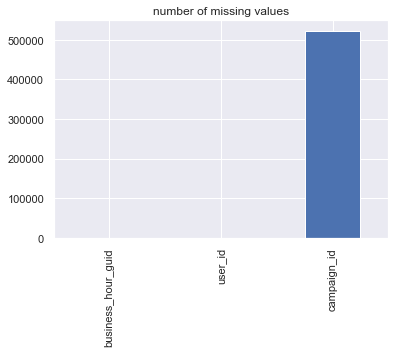

In [31]:
discount.isnull().sum().plot(kind='bar',title='number of missing values') # 檢查空值

In [43]:
discount = discount.drop(columns=['user_id'])

In [33]:
discount = discount.fillna(0) #補空值

In [40]:
def trans(x):
    if x > 0:
        return 1
    else:
        return 0
discount["is_Discount"]=discount["campaign_id"].apply(trans)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
discount=discount.drop_duplicates(['business_hour_guid'])

In [45]:
discount = discount.drop(columns=['campaign_id'])
discount.head()

,business_hour_guid,is_Discount
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,0
1,26C96764-B3FC-480A-AC36-7E23699FAEBE,0
2,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,1
5,06FAD693-D11D-4E04-A164-40880AC1661D,1
8,11C79671-8AB5-4AF3-8967-0D5FEDF446F8,1


In [ ]:
byCategory=byCategory.merge(discount)

In [48]:
byCategory = byCategory.rename(columns={'longTern': 'is_Longtern','presales':'is_Presales'}) #修改欄位名稱


In [51]:
byCategory=byCategory.drop(columns='list')
byCategory.head()

,business_hour_guid,item_orig_price,item_price,code,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,product_launch_month,product_launch_weekday,product_launch_hour,campagin_period,is_Longtern,is_Presales,compare_cate_unit_price,enable_isp,unit_price,category_unit_price,subtotal_guid,quantity_multiplier,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,is_Discount
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,790.0,205.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,2,12,14,0,0,0.823,0.0,205.0,249.0,8405.0,1.0,41.0,8405.0,41.0,205.0,0
1,26C96764-B3FC-480A-AC36-7E23699FAEBE,399.0,269.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,1.080,0.0,269.0,249.0,2152.0,1.0,8.0,2152.0,8.0,269.0,0
2,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,1500.0,568.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,2.281,0.0,568.0,249.0,5680.0,1.0,10.0,5680.0,10.0,568.0,1
3,06FAD693-D11D-4E04-A164-40880AC1661D,3160.0,740.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,2,12,14,0,0,2.972,0.0,740.0,249.0,1480.0,1.0,2.0,1480.0,2.0,740.0,1
4,11C79671-8AB5-4AF3-8967-0D5FEDF446F8,690.0,309.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,28,0,0,1.241,0.0,309.0,249.0,59637.0,1.0,193.0,59637.0,193.0,309.0,1


### 計算開賣前三天之銷量

In [55]:
tmp = pd.to_datetime(df['create_time'])-pd.to_datetime(df['business_hour_order_time_s']) #

In [56]:
df['days_diff'] = 0 
df['days_diff'] = [a.days for a in tmp]  
df.head(3)

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,purchase_year,unit_price,category_unit_price,compare_cate_unit_price,longTern,days_diff
0,3499C728-7CC4-46B4-8FDD-B47AF84DB483,5616D8B6-BB05-45DB-8408-04320DD6E48E,台灣晟龍國際科技有限公司,205.0,0.0,2015-01-01 00:00:15.960,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,2.0,1.112997e+09,0.0,2014-12-31 12:00:00.000,2015-01-14 12:00:00.000,2014-12-31 00:00:00.000,2015-01-23 00:00:00.000,手機殼,234.0,新北市,永和區,閃閃手工水鑽系列手機皮套機殼-時尚奢華風（任選1入方案）,790.0,205.0,20.0,宅配：只要205元(含運)即可帶走原價790元閃閃手工水鑽系列手機皮套機殼-時尚奢華風任選1...,NaN,NaN,1.0,1.0,1.0,[477],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,46.0,46.0,9430.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,2,14,-1,0,2015,205.0,249.0,0.823,0,0
1,F39B9543-DCB2-4013-B1BD-3D8A4276BC46,F3F2A41D-D781-4A95-890A-5A4723C32995,柒叄行銷有限公司,269.0,0.0,2015-01-01 00:10:26.730,26C96764-B3FC-480A-AC36-7E23699FAEBE,3.0,1.111730e+09,0.0,2014-12-19 12:00:00.000,2015-01-09 12:00:00.000,2014-12-19 00:00:00.000,2015-01-14 00:00:00.000,自拍桿,220.0,新北市,板橋區,有線線控自拍桿1組方案,399.0,269.0,20.0,宅配：只要269元(含運)即可購得原價399元有線線控自拍桿1組|顏色：黑/桃/藍。,NaN,NaN,1.0,1.0,1.0,[477|492],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,46.0,42.0,11298.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,4,21,-1,0,2015,269.0,249.0,1.080,0,12
2,BB104E2B-71B1-4B60-89EE-71CFD74C7055,96E11CC9-CF73-404F-AE4A-860C93FF121C,芒果科技有限公司,568.0,0.0,2015-01-01 00:11:47.327,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,3.0,1.112244e+09,0.0,2014-12-26 12:00:00.000,2015-01-16 12:00:00.000,2014-12-26 00:00:00.000,2015-01-21 00:00:00.000,OTG/隨身碟,221.0,新北市,汐止區,4彩手機平板即插即用OTG隨身碟32GB1入方案,1500.0,568.0,20.0,宅配：只要568元(含運)即可購得原價1500元4彩手機平板即插即用OTG隨身碟32GB1入...,NaN,NaN,1.0,1.0,1.0,[477|492],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112763e+09,1.112763e+09,14.0,14.0,7952.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,4,21,-1,0,2015,568.0,249.0,2.281,0,5


In [58]:
df['sales']=df['subtotal']/df['unit_price']

### 計算商品前3天的銷量、銷量占比

In [60]:
total_sales= df.groupby('business_hour_guid')['sales'].sum().to_frame() #總銷售量依檔次分組
total_sales= total_sales.rename(columns={'sales':'total_sales'}) #更改欄位名稱

In [64]:
list = [3]
sales_3days=pd.DataFrame()
for i in list:
    if(i==3):
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['sales'].sum().to_frame()  #i天數內之銷售量
        final_output = final_output.rename(columns={'sales':text})  #更改欄位名稱
        total = pd.merge(total_sales,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   #補空值
        total[text2] = (total[text]/total['total_sales']).round(3) #銷量占比
        sales_3days = total.reset_index() 
    else:
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['sales'].sum().to_frame()  
        final_output = final_output.rename(columns={'sales':text})  
        final_output=final_output.reset_index() 
        total = pd.merge(total_sales,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   
        total[text2] = (total[text]/total['total_sales']).round(3) 
        sales_3days=sales_3days.merge(total)
sales_3days.head(5)

,business_hour_guid,total_sales,sales_3days,ratio_3days
0,00000793-A001-4C8C-9196-3E6971181246,1.0,1.0,1.000
1,00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1.0,0.0,0.000
2,00001928-AE75-4AA9-8A47-4BDE96D08C2D,8.0,0.0,0.000
3,00004599-A7B5-404C-AC84-8AA030B18D3E,30.0,10.0,0.333
4,0000E985-1260-4A96-8A1B-9E899FB0E340,2.0,0.0,0.000


In [67]:
byCategory=byCategory.merge(sales_3days)
byCategory.head(3)

,business_hour_guid,item_orig_price,item_price,code,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,product_launch_month,product_launch_weekday,product_launch_hour,campagin_period,is_Longtern,is_Presales,compare_cate_unit_price,enable_isp,unit_price,category_unit_price,subtotal_guid,quantity_multiplier,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,is_Discount,total_sales,sales_3days,ratio_3days
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,790.0,205.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,2,12,14,0,0,0.823,0.0,205.0,249.0,8405.0,1.0,41.0,8405.0,41.0,205.0,0,41.0,9.0,0.22
1,26C96764-B3FC-480A-AC36-7E23699FAEBE,399.0,269.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,1.080,0.0,269.0,249.0,2152.0,1.0,8.0,2152.0,8.0,269.0,0,8.0,0.0,0.00
2,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,1500.0,568.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,2.281,0.0,568.0,249.0,5680.0,1.0,10.0,5680.0,10.0,568.0,1,10.0,0.0,0.00


### 計算目標變量

In [70]:
total_subtotal= df.groupby('business_hour_guid')['subtotal'].sum().to_frame() #總銷售金額依檔次分組
total_subtotal= total_subtotal.rename(columns={'subtotal':'total_sales_amount'})

In [71]:
list = [7,14,30,60,180]
sales_amount_ratio=pd.DataFrame()
for i in list:
    if(i==7):
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['subtotal'].sum().to_frame()  #i天數內之銷售金額
        final_output = final_output.rename(columns={'subtotal':text})  #更改欄位名稱
        total = pd.merge(total_subtotal,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   #補空值
        total[text2] = (total[text]/total['total_sales_amount']).round(3) #銷量占比
        sales_amount_ratio = total.reset_index() 
    else:
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['subtotal'].sum().to_frame()  
        final_output = final_output.rename(columns={'subtotal':text})  
        final_output=final_output.reset_index() 
        total = pd.merge(total_subtotal,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   
        total[text2] = (total[text]/total['total_sales_amount']).round(3) 
        sales_amount_ratio=sales_amount_ratio.merge(total)
sales_amount_ratio.head(3)

,business_hour_guid,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
0,00000793-A001-4C8C-9196-3E6971181246,399.0,399.0,1.0,399.0,1.0,399.0,1.0,399.0,1.0,399.0,1.0
1,00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1150.0,1150.0,1.0,1150.0,1.0,1150.0,1.0,1150.0,1.0,1150.0,1.0
2,00001928-AE75-4AA9-8A47-4BDE96D08C2D,23040.0,0.0,0.0,11520.0,0.5,23040.0,1.0,23040.0,1.0,23040.0,1.0


In [72]:
byCategory=byCategory.merge(sales_amount_ratio)
byCategory.head(3)

,business_hour_guid,item_orig_price,item_price,code,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,product_launch_month,product_launch_weekday,product_launch_hour,campagin_period,is_Longtern,is_Presales,compare_cate_unit_price,enable_isp,unit_price,category_unit_price,subtotal_guid,quantity_multiplier,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,is_Discount,total_sales,sales_3days,ratio_3days,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,790.0,205.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,2,12,14,0,0,0.823,0.0,205.0,249.0,8405.0,1.0,41.0,8405.0,41.0,205.0,0,41.0,9.0,0.22,8405.0,5740.0,0.683,8405.0,1.000,8405.0,1.0,8405.0,1.0,8405.0,1.0
1,26C96764-B3FC-480A-AC36-7E23699FAEBE,399.0,269.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,1.080,0.0,269.0,249.0,2152.0,1.0,8.0,2152.0,8.0,269.0,0,8.0,0.0,0.00,2152.0,0.0,0.000,269.0,0.125,2152.0,1.0,2152.0,1.0,2152.0,1.0
2,BF2B3D5E-458F-4AA1-B4A8-0E39085CF851,1500.0,568.0,2082.0,0.0,0.0,0.0,0.0,0.0,12,4,12,21,0,0,2.281,0.0,568.0,249.0,5680.0,1.0,10.0,5680.0,10.0,568.0,1,10.0,0.0,0.00,5680.0,1704.0,0.300,3976.0,0.700,5680.0,1.0,5680.0,1.0,5680.0,1.0


In [82]:
byCategory.to_csv('byCategory.csv',index=False)

In [80]:
byCategory.shippingdate=byCategory.shippingdate.fillna(0)

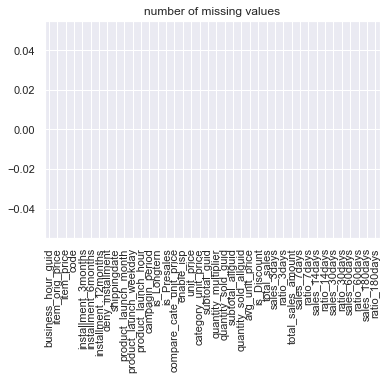

In [81]:
byCategory.isnull().sum().plot(kind='bar',title='number of missing values')
